In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import mglearn

/home/alex/3rd/py-venv/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/alex/3rd/py-venv/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## 3.4.2 非负矩阵分解
非负矩阵分解(non-negative matrix factorization，NMF)是另一种无监督学习算法，其目的在于提取有用的特征。它的工作原理类似于PCA，也可以用于降维。与PCA相同，我们试图将每个数据点写成一些分量的加权求和，如`图3-10`所示。但在PCA中，我们想要的是正交分量，并且能够解释尽可能多的数据方差；而在NMF中，我们希望分量和系数均为非负，也就是说，我们希望分量和系数都大于或等于0。因此，这种方法只能应用于每个特征都是非负的数据，因为非负分量的非负求和不可能变为负值。

将数据分解成非负加权求和的这个过程，对由多个独立源相加(或叠加)创建而成的数据特别有用，比如多人说话的音轨或包含多种乐器的音乐。在这种情况下，NMF可以识别出组成合成数据的原始分量。总的来说，与PCA相比，NMF得到的分量更容易解释，因为负的分量和系数可能会导致难以解释的抵消效应(cancellation effect)。举个例子，`图3-9`中的特征脸同时包含正数和负数，我们在 PCA 的说明中也提到过，正负号实际上是任意的。

在将 NMF 应用于人脸数据集之前，我们先来简要回顾一下模拟数据。

### 3.4.2.1 将NMF应用于模拟数据
与使用PCA不同，我们需要保证数据是正的，NMF能够对数据进行操作。这说明数据相对于原点$(0, 0)$的位置实际上对NMF很重要。因此，你可以将提取出来的非负分量看作是从$(0, 0)$到数据的方向。

下面的例子给出了NMF在二维玩具数据上的结果：

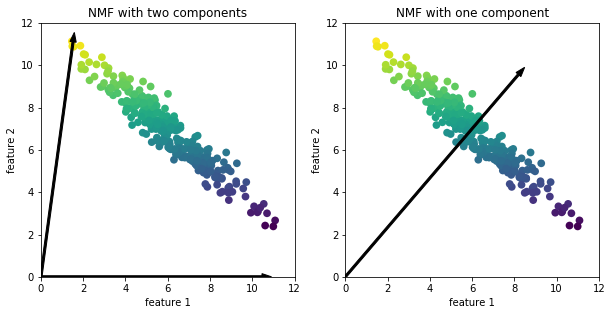

In [2]:
mglearn.plots.plot_nmf_illustration()
plt.gcf().set_size_inches(10, 5)
plt.show()

如左图所示，对于两个分量的NMF，显然所有数据点都可以写成这两个分量的正数组合。如果有足够多的分量能够完美地重建数据（分量个数与特征个数相同），那么算法会选择指向数据极值的方向。

如果我们仅使用一个分量，那么NMF会创建一个指向平均值的分量，因为指向这里可以对数据做出最好的解释。你可以看到，与PCA不同，减少分量个数不仅会删除一些方向，而且会创建一组完全不同的分量！ NMF的分量也没有按任何特定方法排序，所以不存在“第一非负分量”：所有分量的地位平等。

NMF使用了随机初始化，根据随机种子的不同可能会产生不同的结果。在相对简单的情况下(比如两个分量的模拟数据)，所有数据都可以被完美地解释，那么随机性的影响很小(虽然可能会影响分量的顺序或尺度)。在更加复杂的情况下，影响可能会很大。

#### 3.4.2.2 将NMF应用于人脸图像
我们将NMF应用于`Wild数据集`中的`Labeled Faces`。NMF 的主要参数是我们想要提取的分量个数。通常来说，这个数字要小于输入特征的个数（否则的话，将每个像素作为单独的分量就可以对数据进行解释）。通过下图(`图3-14`)我们观察分量个数如何影响NMF重建数据的好坏：

people.images.shape: (3023, 87, 65)
Number of classes: 62


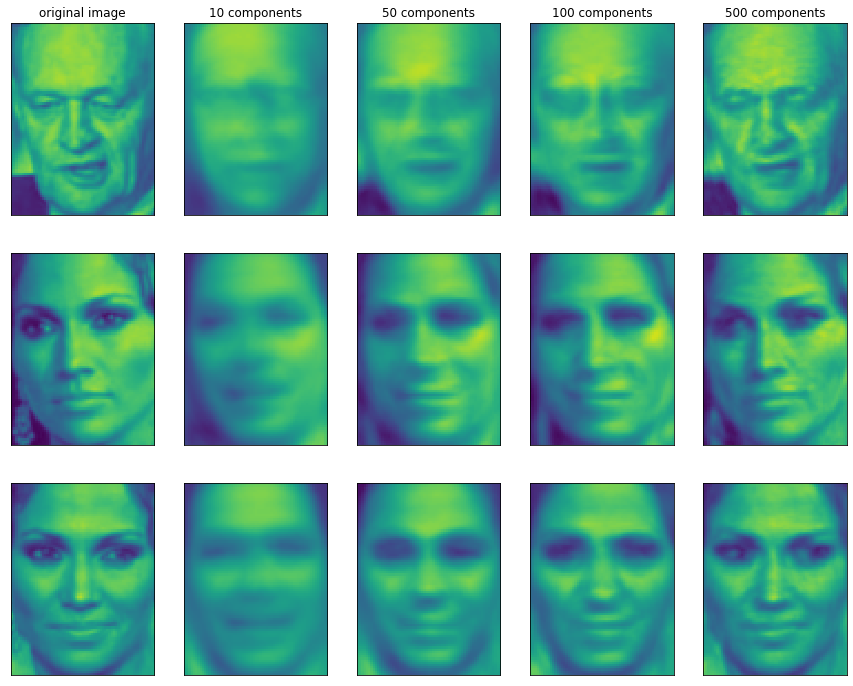

In [3]:
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

print("people.images.shape: {}".format(people.images.shape)) 
print("Number of classes: {}".format(len(people.target_names)))

mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1

X_people = people.data[mask]
y_people = people.target[mask]

# 将灰度值缩放到0到1之间，而不是在0到255之间
# 以得到更好的数据稳定性
X_people = X_people / 255.

# 将数据分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_people, y_people, stratify=y_people, random_state=0)

mglearn.plots.plot_nmf_faces(X_train, X_test, image_shape)
plt.show()

反向变换的数据质量与使用PCA时类似，但要稍差一些。这是符合预期的，因为PCA找到的是重建的最佳方向。NMF通常并不用于对数据进行重建或编码，而是用于在数据中寻找有趣的模式。

我们尝试仅提取一部分分量观察一下数据：

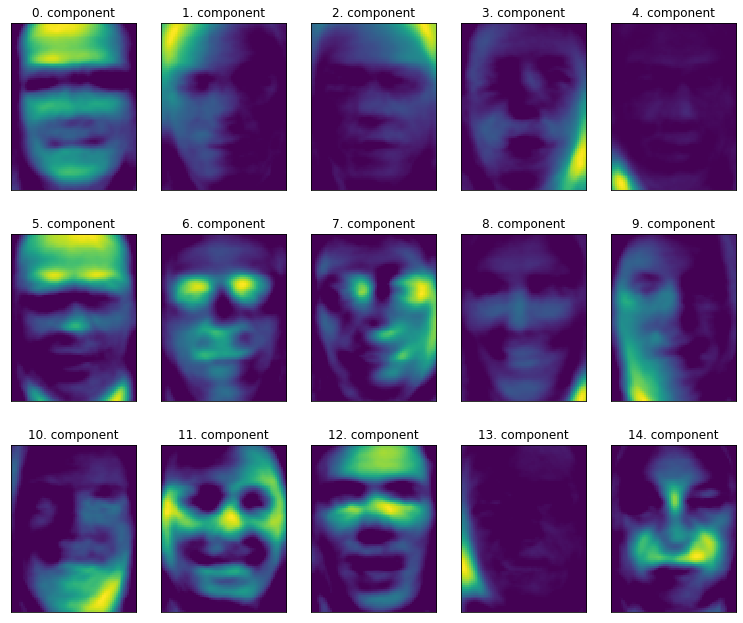

In [4]:
nmf = NMF(n_components=15, random_state=0)
nmf.fit(X_train)
X_train_nmf = nmf.transform(X_train)
X_test_nmf = nmf.transform(X_test)

fix, axes = plt.subplots(3, 5, figsize=(13, 11), subplot_kw={'xticks': (), 'yticks': ()})

for i, (component, ax) in enumerate(zip(nmf.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("{}. component".format(i))
plt.show()

这些分量都是正的，因此比`图3-9`所示的PCA分量更像人脸原型。例如，你可以清楚地看到，分量3(component 3)显示了稍微向右转动的人脸，而分量 7(component 7)则显示了稍微向左转动的人脸。

我们来看一下这两个分量特别大的那些图像，分别如`图3-16`和`图3-17`所示：

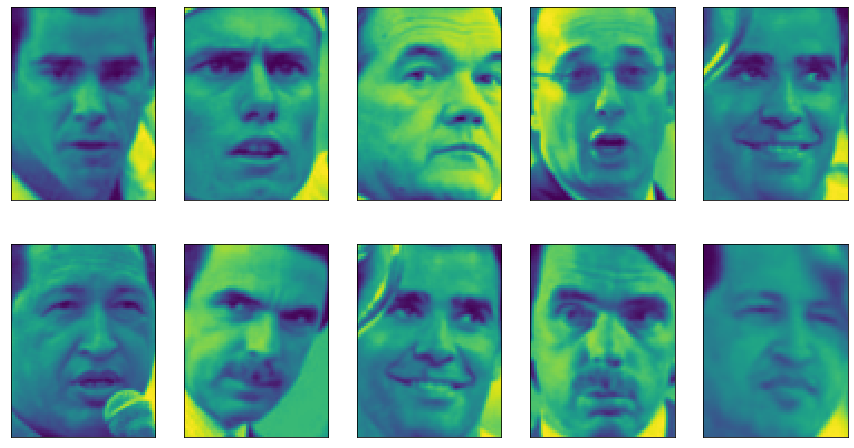

In [5]:
compn = 3
# 按第3个分量排序，绘制前10张图像
inds = np.argsort(X_train_nmf[:, compn])[::-1]
fig, axes = plt.subplots(2, 5, figsize=(15, 8),subplot_kw={'xticks': (), 'yticks': ()})
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))
plt.show()

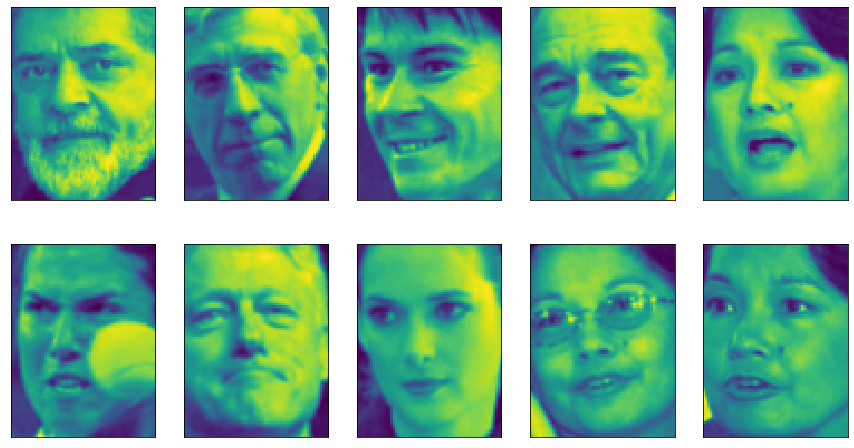

In [6]:
compn = 7
# 按第7个分量排序，绘制前10张图像
inds = np.argsort(X_train_nmf[:, compn])[::-1]
fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))
plt.show()

正如所料，分量3系数较大的人脸都是向右看的人脸，而分量7系数较大的人脸都向左看。如前所述，提取这样的模式最适合于具有叠加结构的数据，包括音频、基因表达和文本数据。我们通过一个模拟数据的例子来看一下这种用法。

假设我们对一个信号感兴趣，它是三个不同信号源合成的，如下图(`图 3-18`)所示：

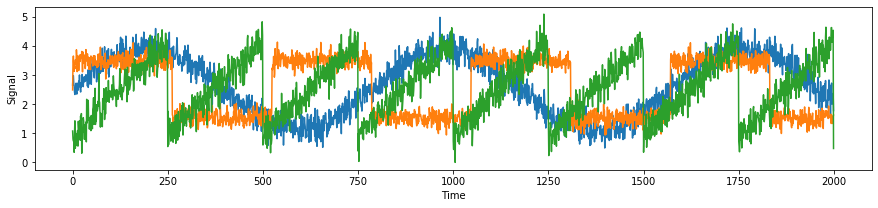

In [7]:
S = mglearn.datasets.make_signals()
plt.plot(S, '-')
plt.xlabel("Time")
plt.ylabel("Signal")
plt.gcf().set_size_inches(15, 3)
plt.show()

不幸的是，我们无法观测到原始信号，只能观测到三个信号的叠加混合。我们想要将混合信号分解为原始分量。假设我们有许多种不同的方法来观测混合信号（比如有100台测量装置），每种方法都为我们提供了一系列测量结果。

In [8]:
# 将数据混合成100*3的随机采样矩阵
A = np.random.RandomState(0).uniform(size=(100, 3))
print("Shape of A: {}".format(A.shape))
X = np.dot(S, A.T)
print("Shape of measurements: {}".format(X.shape))

Shape of A: (100, 3)
Shape of measurements: (2000, 100)


我们可以用NMF来还原这三个信号，为了对比，我们也应用了PCA：

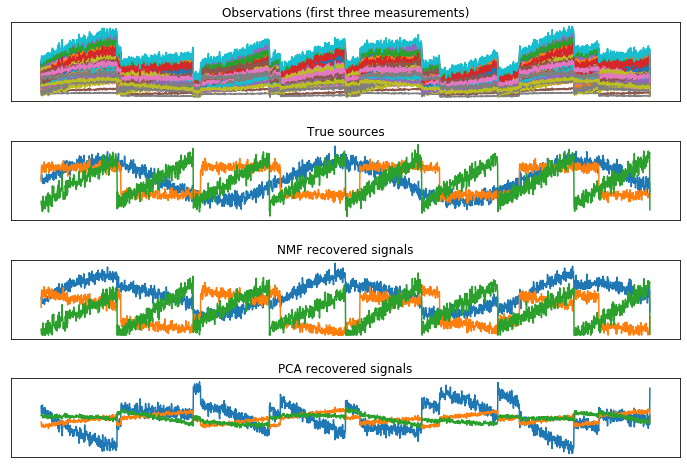

In [9]:
nmf = NMF(n_components=3, random_state=42)
S_ = nmf.fit_transform(X)

pca = PCA(n_components=3)
H = pca.fit_transform(X)

models = [X, S, S_, H]
names = ['Observations (first three measurements)',
         'True sources',
         'NMF recovered signals',
         'PCA recovered signals']

fig, axes = plt.subplots(4, figsize=(12, 8), gridspec_kw={'hspace': .5}, subplot_kw={'xticks': (), 'yticks': ()})

i = 0
for model, name, ax in zip(models, names, axes):
    ax.set_title(name)
    if i == 0:
        # 原文只提取了X第二个维度的三个分量，这里改成使用X的所有分量
        ax.plot(model[:, :], '-')
    else:
        ax.plot(model[:, :3], '-')
    i+=1

plt.show()

图中包含来自$X$的100次测量中的3次，用于参考。可以看到，NMF在发现原始信号源时得到了不错的结果，而PCA则失败了，仅使用第一个成分来解释数据中的大部分变化。要记住，NMF生成的分量是没有顺序的。在这个例子中，NMF分量的顺序与原始信号完全相同（参见三条曲线的颜色），但这纯属偶然。

**还有许多其他算法可用于将每个数据点分解为一系列固定分量的加权求和，正如PCA和NMF所做的那样。讨论所有这些算法已超出了本书的范围，而且描述对分量和系数的约束通常要涉及概率论。如果你对这种类型的模式提取感兴趣，我们推荐你学习`scikit-learn`用户指南中关于独立成分分析(ICA)、因子分析(FA)和稀疏编码（字典学习）等的内容，所有这些内容都可以在关于分解方法的页面中找到(http://scikit-learn.org/stable/modules/decomposition.html)。**